# KD similarity & PSSM similarity

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from katlas.data import *
from scipy.stats import spearmanr
from katlas.clustering import *

In [2]:
# pspa_t5 = pd.read_parquet('train/pspa_t5.parquet')
cddm_t5 = pd.read_parquet('train/cddm_t5.parquet')

In [3]:
df = cddm_t5.copy()

In [4]:
df['0pY'].sort_values()

index
O75385_ULK1_HUMAN_KD1     0.000000
O15530_PDPK1_HUMAN_KD1    0.000000
P78527_PRKDC_HUMAN_KD1    0.000000
Q13535_ATR_HUMAN_KD1      0.000000
Q8IU85_KCC1D_HUMAN_KD1    0.000000
                            ...   
Q15303_ERBB4_HUMAN_KD1    0.933654
P22455_FGFR4_HUMAN_KD1    0.936460
P54764_EPHA4_HUMAN_KD1    0.936728
P10721_KIT_HUMAN_KD1      0.939353
Q15375_EPHA7_HUMAN_KD1    0.939747
Name: 0pY, Length: 321, dtype: float64

In [5]:
st = df[df['0pY']<0.7].copy()
tyr = df[df['0pY']>=0.7].copy()

In [6]:
def euclidean_dist(u, v):
    return norm(u - v)

In [7]:
def get_dist(df):
    df =df.copy()
    t5_cols = df.columns[df.columns.str.startswith('T5')]
    pssm_cols = df.columns[~df.columns.str.startswith('T5')]
    D_pssm = get_1d_js(df[pssm_cols])
    D_t5 = get_1d_distance(df[t5_cols],func_flat=euclidean_dist)
    return D_t5,D_pssm

In [15]:
D_t5,D_pssm= get_dist(st)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:03<00:00, 68.25it/s]


In [16]:
D_t5_y,D_pssm_y= get_dist(tyr)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 212.37it/s]


In [13]:
def plot_scatter(x, y,line=None):
    plt.figure(figsize=(4,3), dpi=300)
    plt.scatter(x, y, s=3, alpha=0.3)

    # labels
    plt.xlabel("Euclidean distance in T5 embeddings of KDs")
    plt.ylabel("JS divergence in PSSMs")

    # calculate Spearman correlation
    rho, pval = spearmanr(x, y)

    # annotate Spearman correlation coefficient on the plot
    plt.text(0.95, 0.95, f"Spearman ρ = {rho:.3f}", 
             ha="right", va="top", transform=plt.gca().transAxes,
             fontsize=10, bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    if line is not None: plt.axvline(x=line, color="darkred", alpha=0.7,linestyle="--", linewidth=1)
    plt.tight_layout()

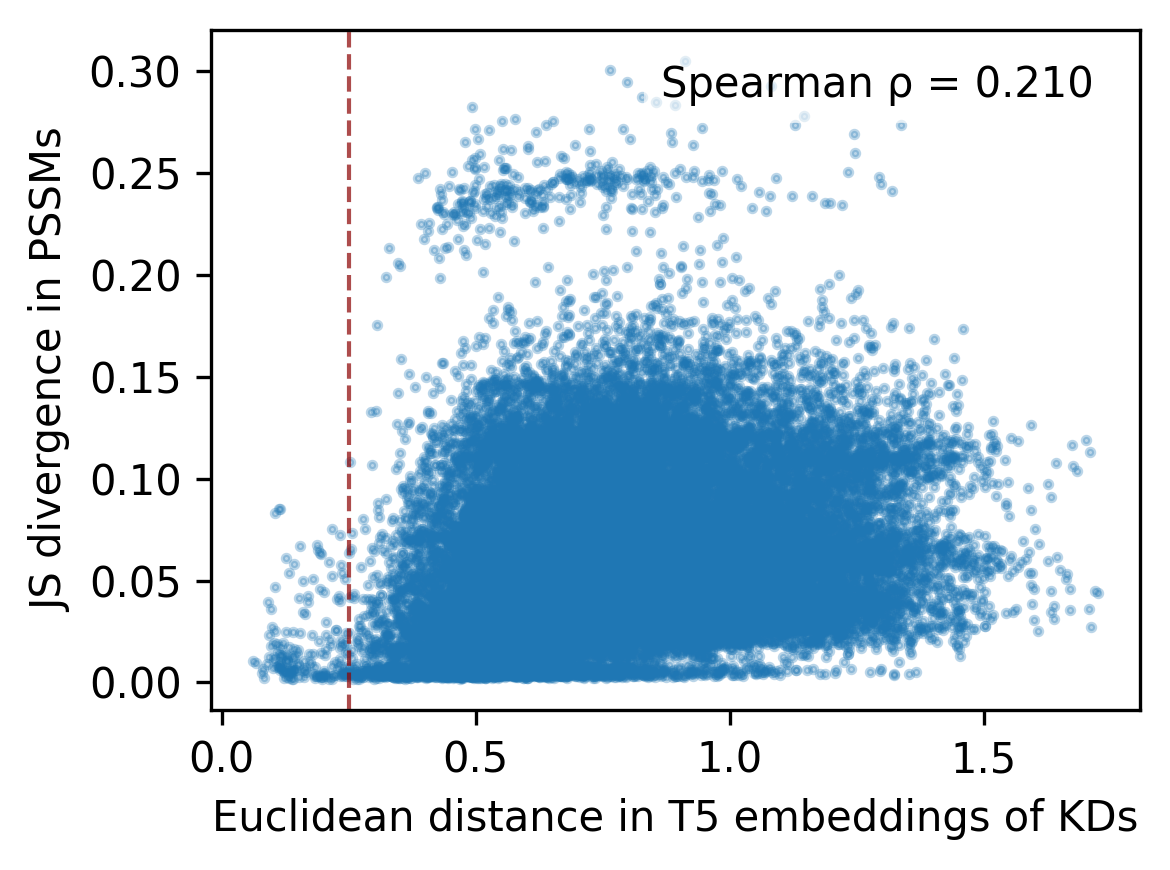

In [14]:
plot_scatter(D_t5,D_pssm,line=0.25)

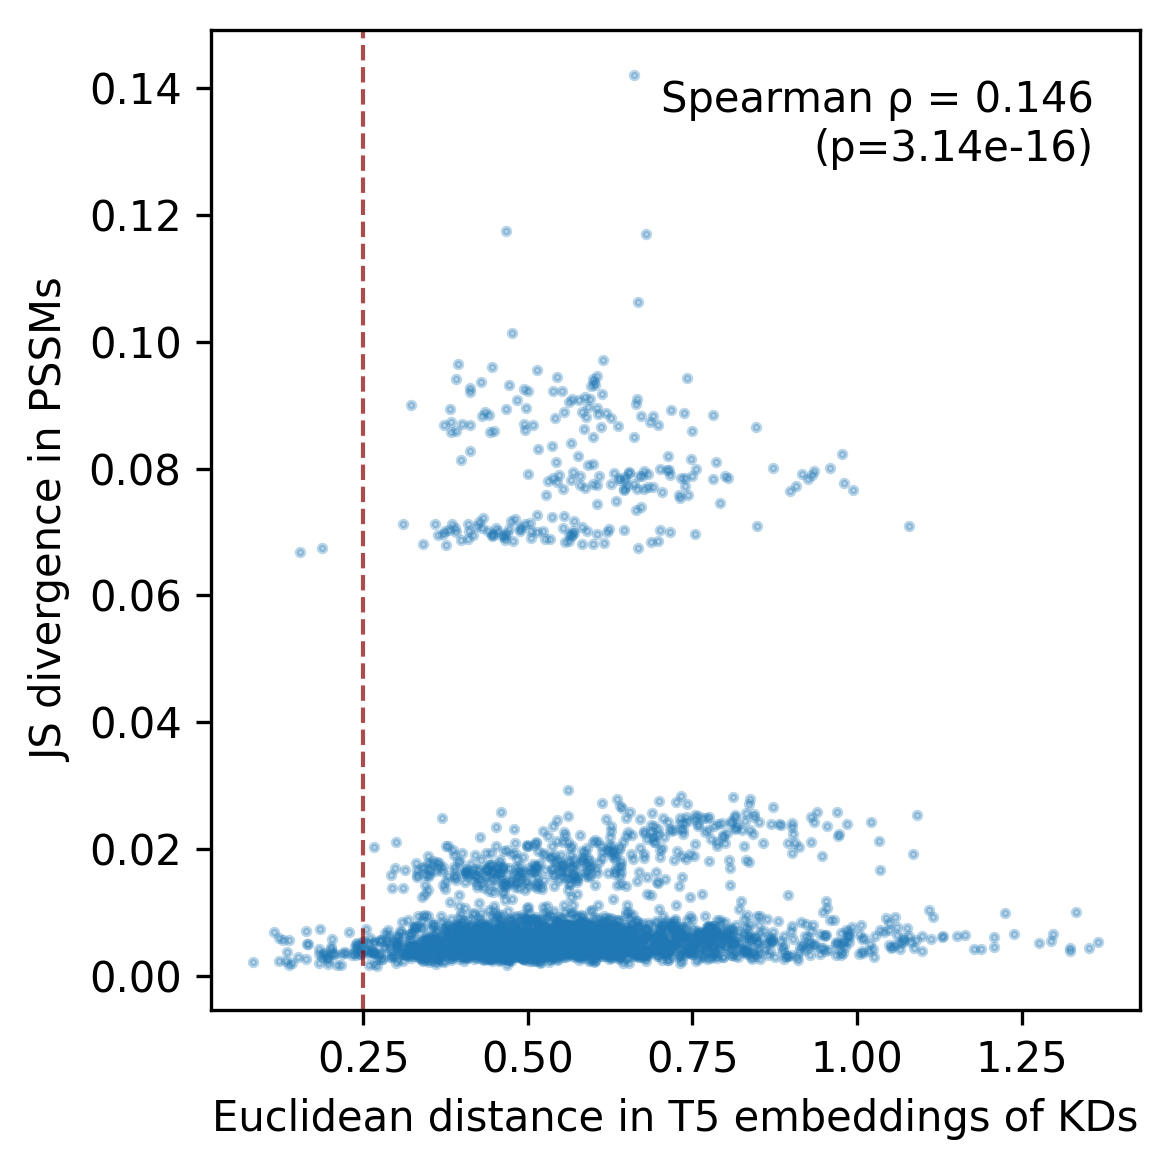

In [22]:
plot_scatter(D_t5_y,D_pssm_y,line=0.25)

## Distance in all kd

In [23]:
df  = Data.get_kd_uniprot()

In [25]:
# df['in_pspa']  = df.kd_ID.isin(pspa_t5.index).astype(int)
df['in_cddm']  = df.kd_ID.isin(cddm_t5.index).astype(int)

In [26]:
from katlas.feature import *

In [27]:
# t5 = get_t5(df,col='kd_seq')

# t5.index=df.kd_ID

# t5 = t5.astype('float64')

# t5.to_parquet('out/uniprot_kd_t5.parquet')

In [28]:
t5_df = pd.read_parquet('out/uniprot_kd_t5.parquet')

In [29]:
def find_close_negatives(df: pd.DataFrame,
                         label_series,
                         threshold: float = 0.25,
                         return_all: bool = False) -> pd.DataFrame:
    """
    For each negative (label_col==0), find the nearest positive (label_col==1)
    by Euclidean distance over `features`, and mark whether it's within `threshold`.

    Returns a DataFrame indexed by the negatives' index with columns:
      - closest_pos_index
      - closest_dist
      - within_threshold (bool)
    If `return_all=False`, only rows within threshold are returned.
    """

    # Extract arrays
    mask_pos = label_series.eq(1).to_numpy()
    mask_neg = ~mask_pos

    X_pos = df.loc[mask_pos].to_numpy(dtype=float, copy=False)
    X_neg = df.loc[mask_neg].to_numpy(dtype=float, copy=False)

    # Handle edge cases
    if X_pos.size == 0 or X_neg.size == 0:
        out = pd.DataFrame(columns=["closest_pos_index", "closest_dist", "within_threshold"],
                           index=df.index[mask_neg])
        return out if return_all else out.iloc[0:0]

    # Pairwise squared distances: ||a-b||^2 = ||a||^2 + ||b||^2 - 2 a·b
    sq_pos = np.einsum('ij,ij->i', X_pos, X_pos)            # (P,)
    sq_neg = np.einsum('ij,ij->i', X_neg, X_neg)            # (N,)
    D2 = sq_neg[:, None] + sq_pos[None, :] - 2.0 * (X_neg @ X_pos.T)
    np.maximum(D2, 0.0, out=D2)                             # numerical safety
    # Nearest positive for each negative
    idx_min = D2.argmin(axis=1)                             # (N,)
    dmin = np.sqrt(D2[np.arange(D2.shape[0]), idx_min])     # (N,)

    # Map back to indices
    pos_index = df.index[mask_pos].to_numpy()
    neg_index = df.index[mask_neg].to_numpy()
    closest_pos_index = pos_index[idx_min]

    out = pd.DataFrame({
        "closest_pos_index": closest_pos_index,
        "closest_dist": dmin,
        "within_threshold": dmin <= threshold,
    }, index=neg_index)

    return out if return_all else out[out["within_threshold"]]

In [33]:
results_cddm = find_close_negatives(t5_df, label_series=df.in_cddm,
                                   threshold=0.25, return_all=True)

In [36]:
# results_cddm.to_parquet('out/kd_similar_cddm.parquet')

In [34]:
results_cddm

,closest_pos_index,closest_dist,within_threshold
A0A075F7E9_LERK1_ORYSI_KD1,Q9NYL2_M3K20_HUMAN_KD1,0.825920,False
A0A078BQP2_GCY25_CAEEL_KD1,O43353_RIPK2_HUMAN_KD1,0.816974,False
A0A078CGE6_M3KE1_BRANA_KD1,Q8NG66_NEK11_HUMAN_KD1,0.447534,False
A0A0G2K344_PK3CA_RAT_KD1,Q13535_ATR_HUMAN_KD1,0.451836,False
A0A0H2ZM62_HK06_STRP2_KD1,Q96KB5_TOPK_HUMAN_KD1,1.075406,False
...,...,...,...
W0LYS5_CAMKI_MACNP_KD1,Q14012_KCC1A_HUMAN_KD1,0.175058,True
W0T9X4_ATG1_KLUMD_KD1,P51955_NEK2_HUMAN_KD1,0.664876,False
W7JX98_KGP_PLAFO_KD1,Q13237_KGP2_HUMAN_KD1,0.480042,False
X5M5N0_WNK_CAEEL_KD1,Q9Y3S1_WNK2_HUMAN_KD1,0.316293,False


In [35]:
results_cddm[results_cddm.within_threshold].sort_values('closest_dist')

,closest_pos_index,closest_dist,within_threshold
Q62829_PAK3_RAT_KD1,O75914_PAK3_HUMAN_KD1,0.000000,True
Q63644_ROCK1_RAT_KD1,Q13464_ROCK1_HUMAN_KD1,0.000000,True
Q06486_KC1D_RAT_KD1,P48730_KC1D_HUMAN_KD1,0.000000,True
Q04982_BRAF_CHICK_KD1,P15056_BRAF_HUMAN_KD1,0.000000,True
Q08E52_PAK1_BOVIN_KD1,Q13153_PAK1_HUMAN_KD1,0.000000,True
...,...,...,...
O08605_MKNK1_MOUSE_KD1,Q9HBH9_MKNK2_HUMAN_KD1,0.248701,True
P87253_KPC1_NEUCR_KD1,Q04759_KPCT_HUMAN_KD1,0.249016,True
P47817_WEE2A_XENLA_KD1,P30291_WEE1_HUMAN_KD1,0.249110,True
Q9W739_CDK1_RANDY_KD1,P06493_CDK1_HUMAN_KD1,0.249479,True
